In [1]:
import colour
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
red_wavelength, green_wavelength, blue_wavelength = 644, 515, 467.83

def create_theta_array(height, width, angle_of_view):
    x = np.arange(-width//2, width//2)
    y = np.arange(-height//2, height//2)
    z = np.sqrt(x[-1]**2 + y[-1]**2) / np.tan(angle_of_view)
    X, Y = np.meshgrid(x, y)
    return np.arctan(np.sqrt(X**2 + Y**2) / z)

def transform_wavelength(wavelength, beta, THETA):
    gamma = 1 / np.sqrt(1 - beta ** 2)
    return np.clip(wavelength / (gamma * (1 - beta * np.cos(THETA))), 380, 750)

def interpolate_wavelength_to_rgb():
    wavelengths = np.arange(380, 751, 0.01)
    xyz = colour.wavelength_to_XYZ(wavelengths)
    rgb = colour.XYZ_to_sRGB(xyz)
    r, g, b = np.clip(rgb, 0, 1).T
    r_func = interp1d(wavelengths, r, kind='cubic')
    g_func = interp1d(wavelengths, g, kind='cubic')
    b_func = interp1d(wavelengths, b, kind='cubic')
    return r_func, g_func, b_func

def wavelength_to_rgb(wavelength):
    r_func, g_func, b_func = interpolate_wavelength_to_rgb()
    return np.stack((r_func(wavelength), g_func(wavelength), b_func(wavelength)), axis=-1) 

def transform_pixels(rgb_channels, rgb_trans):
    pixels_trans = 0
    for i in range(3):
        pixels_trans += rgb_trans[i] * rgb_channels[:, :, i][..., np.newaxis]
    return pixels_trans.astype(int)

def transform_image(file, beta, angle_of_view):
    image = Image.open(f'images/originals/{file}')
    image = image.convert('RGB')
    rgb_channels = np.array(image)
    height, width, _ = rgb_channels.shape

    THETA = create_theta_array(height, width, angle_of_view)

    red_wavelength_trans = transform_wavelength(red_wavelength, beta, THETA)
    green_wavelength_trans = transform_wavelength(green_wavelength, beta, THETA)
    blue_wavelength_trans = transform_wavelength(blue_wavelength, beta, THETA)

    red_rgb_trans = wavelength_to_rgb(red_wavelength_trans)
    green_rgb_trans = wavelength_to_rgb(green_wavelength_trans)
    blue_rgb_trans = wavelength_to_rgb(blue_wavelength_trans)
    rgb_trans = [red_rgb_trans, green_rgb_trans, blue_rgb_trans]

    pixels_trans = transform_pixels(rgb_channels, rgb_trans)
    fig, ax = plt.subplots(figsize=(width / 200, height / 200))
    ax.imshow(pixels_trans)
    ax.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    folder = 'blueshifted' if beta < 0 else 'redshifted'
    plt.savefig(f'images/{folder}/alpha={int(np.degrees(angle_of_view))}°_beta={beta}_{file}', bbox_inches='tight', pad_inches=0)

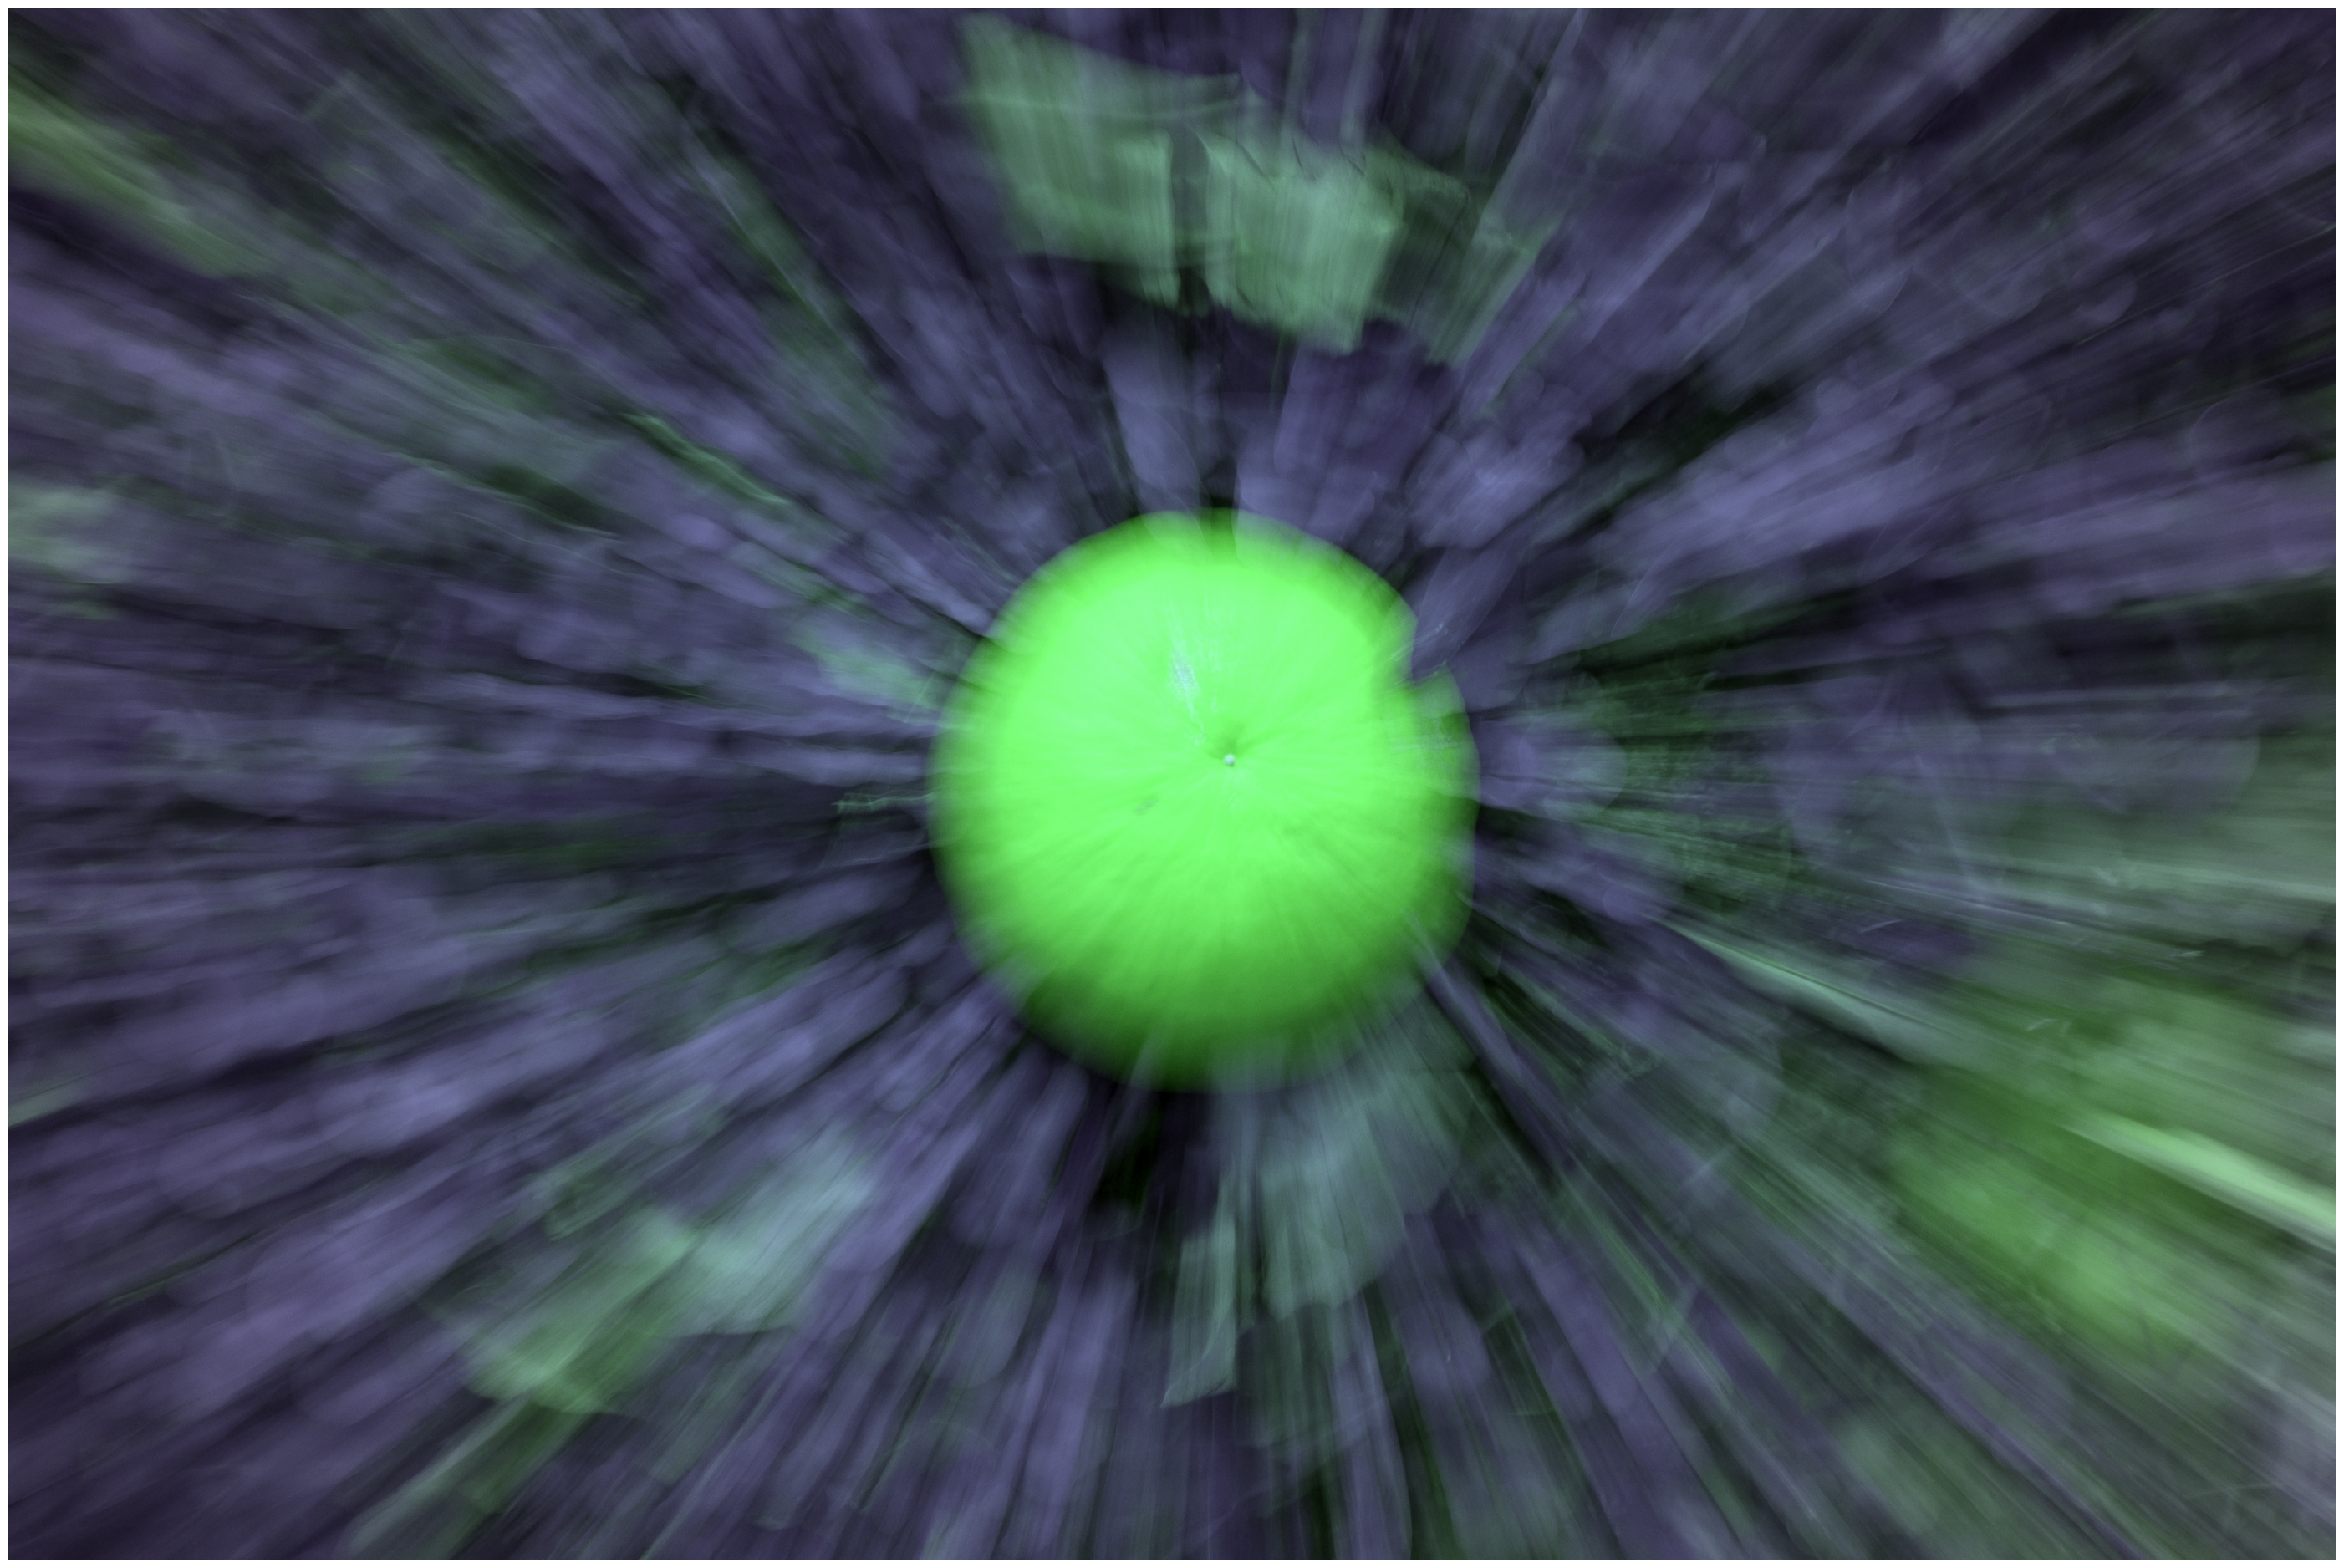

In [11]:
transform_image('_DSC1575.jpg', -0.15, np.radians(13))